# Installing / Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from pandas import to_datetime
from datetime import datetime, date 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

# grid search sarima hyperparameters
from math import sqrt

import multiprocessing
multiprocessing.set_start_method('spawn', True)
from multiprocessing import cpu_count

from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools

from tabulate import tabulate

In [2]:
matplotlib.rcParams['figure.figsize'] = (10,5)

# Data Exploration

In [3]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data

,date,Inquiries_NonStat,Inquiries_Stat
0,2017-01-01,7574.0,NaN
1,2017-01-02,13189.0,NaN
2,2017-01-03,24678.0,NaN
3,2017-01-04,23380.0,1.320733
4,2017-01-05,22809.0,1.247026
...,...,...,...
2095,2022-09-27,11598.0,1.178299
2096,2022-09-28,11886.0,1.298347
2097,2022-09-29,11772.0,NaN
2098,2022-09-30,10669.0,NaN


In [4]:
Daily_data.set_index('date', inplace = True)
Daily_data.isna().any()

Inquiries_NonStat    False
Inquiries_Stat        True
dtype: bool

In [5]:
Daily_data.describe()

,Inquiries_NonStat,Inquiries_Stat
count,2100.000000,2094.000000
mean,14234.188571,0.998492
std,5816.090211,0.328633
min,96.000000,0.038536
25%,9733.750000,0.599834
50%,13863.500000,1.145044
75%,19307.000000,1.233318
max,30619.000000,2.227288


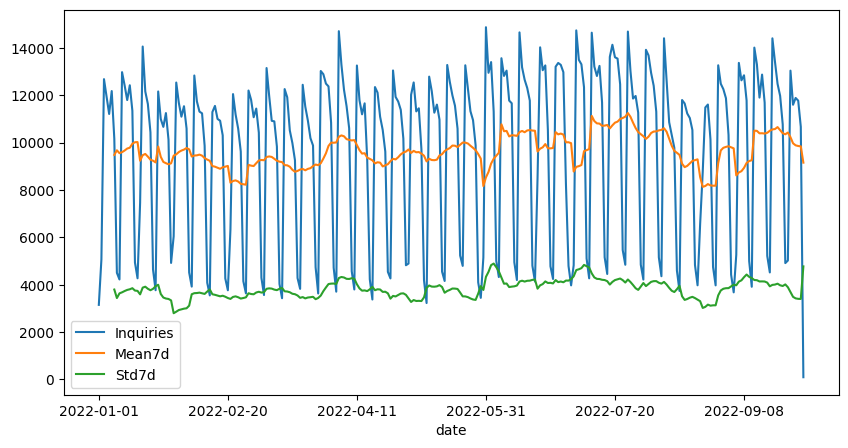

In [6]:
Daily_data.loc['2022-01-01' :]['Inquiries_NonStat'].plot(label='Inquiries')
Daily_data.loc['2022-01-01' :].rolling(window=7).mean()['Inquiries_NonStat'].plot(label='Mean7d')
Daily_data.loc['2022-01-01' :].rolling(window=7).std()['Inquiries_NonStat'].plot(label='Std7d')
plt.legend()

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if(dfoutput['Test Statistic'] <= dfoutput['Critical Value (%s)'%key] ):
            print('Stationary')
        else:
            print('Non-Stationary')
    print ()
    print (dfoutput)
    print ()
    
adf_test(Daily_data['Inquiries_NonStat'].dropna()) 
# Test Statistics > Critical value (Should be TS <= CV to reject)
# p-value  0.05 (Should be p-value <= significance level to reject)

# Failed to Reject Null hypothesis -- > Non-Stationary data 

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        if(kpss_output['Test Statistic'] > kpss_output['Critical Value (%s)'%key] ):
            print('Non-Stationary')
        else:
            print('Stationary')
    print ()
    print (kpss_output)
    print ()
kpss_test(Daily_data['Inquiries_NonStat'].dropna())
# Test Statistics > Critical value (Should be TS > CV to reject)
# p-value < 0.05 (Should be p-value > significance level to reject)
# Rejected Null hypothesis -- > Non stationary data 

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -1.971946
p-value                           0.299008
#Lags Used                       26.000000
Number of Observations Used    2073.000000
Critical Value (1%)              -3.433508
Critical Value (5%)              -2.862935
Critical Value (10%)             -2.567513
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.122761
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF test & KPSS test --> Non-Stationary

# Train-Test split

In [8]:
#Daily_data.set_index('date', inplace = True)
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)

train_df = Daily_data.iloc[:1680]
test_df  = Daily_data.iloc[1679:]
train_df.index = pd.to_datetime(train_df.index)
test_df.index = pd.to_datetime(test_df.index)

C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


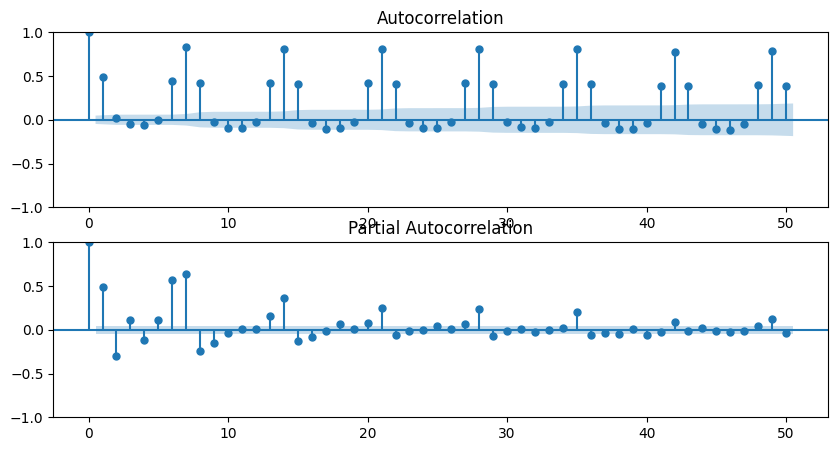

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train_df, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_df, lags=50, ax=ax[1])
plt.show()

p and P both equal 1 (significant positive spikes in ACF and PACF plots)
d and D both equal 1 (first difference and seasonal difference)
q and Q both equal 0 & 1 (no significant negative spikes)
s equal to 7 (weekly seasonal component)

Optimization terminated successfully.
         Current function value: 9.198423
         Iterations: 3
         Function evaluations: 149


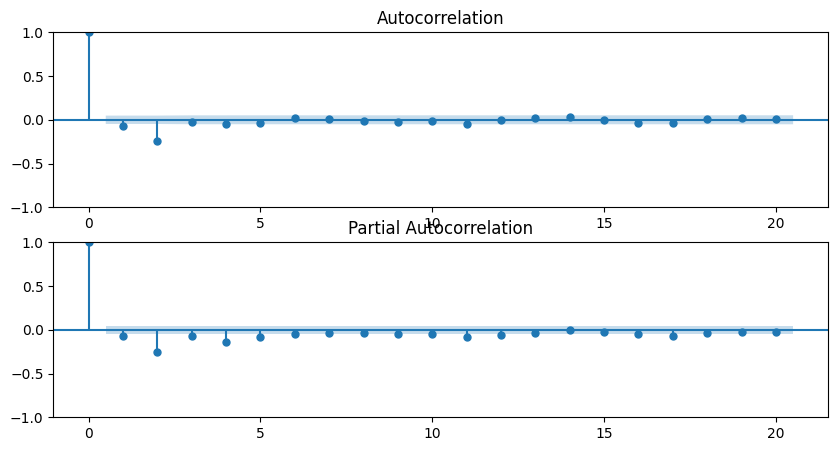

In [10]:
filterwarnings("ignore")
model = sm.tsa.statespace.SARIMAX(train_df, order=(1,1,0), seasonal_order=(1,1,1,7)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax[1])
plt.show()

# SARIMA(2, 1, 1)	(1, 1, 1, 7)	AIC --> 30639.717227

## Lead time = 0 & single - step ahead

In [11]:
#%pip install holidays

## SARIMAX: Exogenous var - Holidays

In [12]:
import holidays

nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019,2020,2021,2022])

for date, name in nyc_holidays.items():
    print(date, name)

2017-01-01 New Year's Day
2017-01-02 New Year's Day (Observed)
2017-01-16 Martin Luther King Jr. Day
2017-02-12 Lincoln's Birthday
2017-02-13 Lincoln's Birthday (Observed)
2017-02-15 Susan B. Anthony Day
2017-02-20 Washington's Birthday
2017-05-29 Memorial Day
2017-07-04 Independence Day
2017-09-04 Labor Day
2017-10-09 Columbus Day
2017-11-07 Election Day
2017-11-11 Veterans Day
2017-11-10 Veterans Day (Observed)
2017-11-23 Thanksgiving
2017-12-25 Christmas Day
2018-01-01 New Year's Day
2018-01-15 Martin Luther King Jr. Day
2018-02-12 Lincoln's Birthday
2018-02-15 Susan B. Anthony Day
2018-02-19 Washington's Birthday
2018-05-28 Memorial Day
2018-07-04 Independence Day
2018-09-03 Labor Day
2018-10-08 Columbus Day
2018-11-06 Election Day
2018-11-11 Veterans Day
2018-11-12 Veterans Day (Observed)
2018-11-22 Thanksgiving
2018-12-25 Christmas Day
2019-01-01 New Year's Day
2019-01-21 Martin Luther King Jr. Day
2019-02-12 Lincoln's Birthday
2019-02-15 Susan B. Anthony Day
2019-02-18 Washingto

In [13]:
Daily_data = Daily_data.reset_index()
Daily_data['date'] = pd.to_datetime(Daily_data['date'])
Daily_data = Daily_data.set_index('date')

In [24]:
df=Daily_data
# Create a DataFrame of holidays
holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holidays_df = holidays_df.set_index(['date'])

# Join the holidays DataFrame with the original DataFrame
df = df.join(holidays_df, on='date')
df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)
df

,Inquiries_NonStat,holiday
date,,
2017-01-01,7574.0,1.0
2017-01-02,13189.0,1.0
2017-01-03,24678.0,0.0
2017-01-04,23380.0,0.0
2017-01-05,22809.0,0.0
...,...,...
2022-09-26,13039.0,0.0
2022-09-27,11598.0,0.0
2022-09-28,11886.0,0.0


In [15]:
# Create an empty table
table = []
data = df
n_test = 1679 #point where data is split into training and test sets
train, test = data[:n_test], data[n_test:]
# Add the column names
table.append(["param", "param_seasonal", "AIC"])

import itertools
#set parameter range
p = range(1,3)
q = range(1,3)
d = range(1,2)
s = range(7,8)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']],
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            table.append([param, param_seasonal, results.aic])
        except:
            continue


Optimization terminated successfully.
         Current function value: 8.945271
         Iterations: 5
         Function evaluations: 338
SARIMA(1, 1, 1),(1, 1, 1, 7) - AIC:30050.21901057335
Optimization terminated successfully.
         Current function value: 8.945663
         Iterations: 4
         Function evaluations: 324
SARIMA(1, 1, 1),(1, 1, 2, 7) - AIC:30053.53638948392
Optimization terminated successfully.
         Current function value: 8.943855
         Iterations: 6
         Function evaluations: 478
SARIMA(1, 1, 1),(2, 1, 1, 7) - AIC:30047.46374431767
Optimization terminated successfully.
         Current function value: 8.948057
         Iterations: 4
         Function evaluations: 369
SARIMA(1, 1, 1),(2, 1, 2, 7) - AIC:30063.576673047617
Optimization terminated successfully.
         Current function value: 8.948593
         Iterations: 3
         Function evaluations: 236
SARIMA(1, 1, 2),(1, 1, 1, 7) - AIC:30063.374302256685
Optimization terminated successfully.
     

In [16]:
table1 = tabulate(table)
print(table1)

---------  --------------  ------------------
param      param_seasonal  AIC
(1, 1, 1)  (1, 1, 1, 7)    30050.21901057335
(1, 1, 1)  (1, 1, 2, 7)    30053.53638948392
(1, 1, 1)  (2, 1, 1, 7)    30047.46374431767
(1, 1, 1)  (2, 1, 2, 7)    30063.576673047617
(1, 1, 2)  (1, 1, 1, 7)    30063.374302256685
(1, 1, 2)  (1, 1, 2, 7)    30065.9449203689
(1, 1, 2)  (2, 1, 1, 7)    30065.144673861956
(1, 1, 2)  (2, 1, 2, 7)    30067.267335613797
(2, 1, 1)  (1, 1, 1, 7)    30110.957093134442
(2, 1, 1)  (1, 1, 2, 7)    30114.717503059026
(2, 1, 1)  (2, 1, 1, 7)    30110.03033088815
(2, 1, 1)  (2, 1, 2, 7)    30115.36577048923
(2, 1, 2)  (1, 1, 1, 7)    30051.220521104362
(2, 1, 2)  (1, 1, 2, 7)    30057.415442040117
(2, 1, 2)  (2, 1, 1, 7)    30053.351080226224
(2, 1, 2)  (2, 1, 2, 7)    30057.112712621965
---------  --------------  ------------------


In [23]:
scores_data = np.array(table)
df_random = pd.DataFrame(table)
df_random.columns=df_random.iloc[0] 
df_random = df_random.drop(index=0,axis=0)
minAIC = df_random['AIC'].min()
df_random[df_random['AIC'] == minAIC]

,param,param_seasonal,AIC
3,"(1, 1, 1)","(2, 1, 1, 7)",30047.463744


# SARIMA(2, 1, 1)	(1, 1, 1, 7)	AIC --> 30639.717227
# SARIMAX(1, 1, 1)	(2, 1, 1, 7)	AIC --> 30047.463744
## SARIMAX Model Predictions

In [25]:
data = df
n_test = 1679 #point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    
    predictions = np.array([])
    rmse_list = []
    train, test = data[:n_test], data[n_test:]
    day_list = [1*x for x in range(1,int(len(test))+1)] # days 1,2,3,4 --> [1,2,3,4,..,420]
    for i in day_list:
        exog_forecast = test[i-1:i][['holiday']]
        # Fit model to training data
        model2 = SARIMAX(train[['Inquiries_NonStat']], exog = train[['holiday']], order=(1,1,1), seasonal_order = (2,1,1,7)).fit(max_iter = 50, method = 'powell')
        
        # Forecast daily loads for week i
        forecast = model2.forecast(steps = 1, exog=exog_forecast)
        predictions = np.concatenate((predictions, forecast), axis=None)
        
        # Calculate RMSE and add to RMSE_list
        j = i-1
        rmse_score = sqrt(mean_squared_error(test[j:i][['Inquiries_NonStat']], predictions[j:i]))
        #mape_mean = mape_score.mean()
        rmse_list.append(rmse_score)
        # Add week i to training data for next loop
        train = pd.concat([train, test[j:i]])
        #train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, rmse_list

predictions, rmse_list = walk_forward_validation(data, n_test)

Optimization terminated successfully.
         Current function value: 8.943855
         Iterations: 6
         Function evaluations: 478
Optimization terminated successfully.
         Current function value: 8.943578
         Iterations: 6
         Function evaluations: 478
Optimization terminated successfully.
         Current function value: 8.943301
         Iterations: 6
         Function evaluations: 478
Optimization terminated successfully.
         Current function value: 8.943023
         Iterations: 6
         Function evaluations: 478
Optimization terminated successfully.
         Current function value: 8.942797
         Iterations: 6
         Function evaluations: 478
Optimization terminated successfully.
         Current function value: 8.942521
         Iterations: 6
         Function evaluations: 478
Optimization terminated successfully.
         Current function value: 8.942245
         Iterations: 6
         Function evaluations: 478
Optimization terminated successful

In [26]:
test_df['Ex_Holiday_Preds'] = predictions
test_df['Ex_Holiday_Error'] = rmse_list
Ex_HolidayRMSE_single = test_df['Ex_Holiday_Error'].mean()
test_df,Ex_HolidayRMSE_single

(            Inquiries_NonStat  Ex_Holiday_Preds  Ex_Holiday_Error
 date                                                             
 2021-08-07             5879.0       5667.723450        211.276550
 2021-08-08             4960.0       5145.687265        185.687265
 2021-08-09            14917.0      14750.762038        166.237962
 2021-08-10            13359.0      14160.145391        801.145391
 2021-08-11            13114.0      12922.435575        191.564425
 ...                       ...               ...               ...
 2022-09-26            13039.0      13374.753742        335.753742
 2022-09-27            11598.0      13011.614335       1413.614335
 2022-09-28            11886.0      11635.114313        250.885687
 2022-09-29            11772.0      11903.725900        131.725900
 2022-09-30            10669.0      10778.391318        109.391318
 
 [420 rows x 3 columns],
 642.8313264157767)

In [27]:
test_df['holiday'] = df['holiday']['2021-08-07':]
test_df

,Inquiries_NonStat,Ex_Holiday_Preds,Ex_Holiday_Error,holiday
date,,,,
2021-08-07,5879.0,5667.723450,211.276550,0.0
2021-08-08,4960.0,5145.687265,185.687265,0.0
2021-08-09,14917.0,14750.762038,166.237962,0.0
2021-08-10,13359.0,14160.145391,801.145391,0.0
2021-08-11,13114.0,12922.435575,191.564425,0.0
...,...,...,...,...
2022-09-26,13039.0,13374.753742,335.753742,0.0
2022-09-27,11598.0,13011.614335,1413.614335,0.0
2022-09-28,11886.0,11635.114313,250.885687,0.0


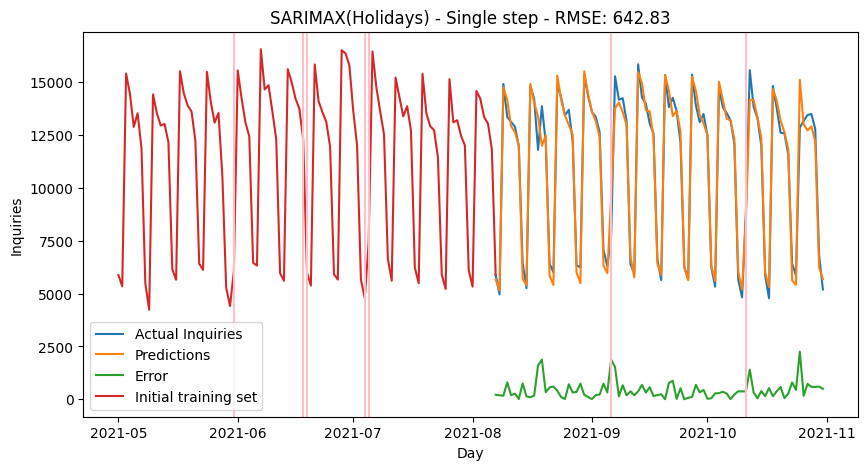

In [28]:
plt.title('SARIMAX(Holidays) - Single step - RMSE: 642.83')
plt.plot(test_df[:'2021-10-31'][['Inquiries_NonStat',	'Ex_Holiday_Preds'	,'Ex_Holiday_Error']], label = ['Actual Inquiries','Predictions','Error'])
plt.plot(train_df['2021-05-01':], label = 'Initial training set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()


# Add a vertical line at x=0
for i, row in df['holiday']['2021-05-01':'2021-10-31'].iteritems():
    if row != 0:
        plt.axvline(x = i, color='pink', linestyle='-')
plt.show()

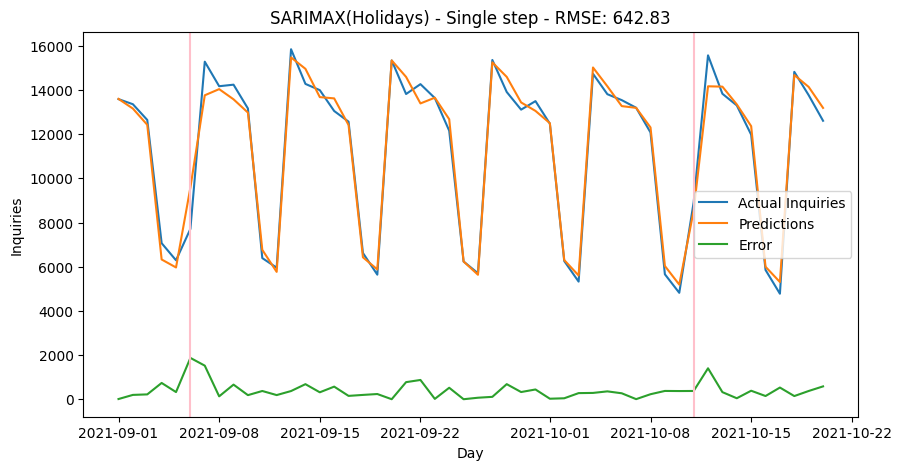

In [29]:
plt.title('SARIMAX(Holidays) - Single step - RMSE: 642.83')
plt.plot(test_df['2021-09-01':'2021-10-20'][['Inquiries_NonStat',	'Ex_Holiday_Preds'	,'Ex_Holiday_Error']], label = ['Actual Inquiries','Predictions','Error'])
#plt.plot(train_df['2021-05-01':], label = 'Initial training set')
plt.xlabel('Day')
plt.ylabel('Inquiries')

for i, row in df['holiday']['2021-09-01':'2021-10-20'].iteritems():
    if row != 0:
        plt.axvline(x = i, color='pink', linestyle='-')
plt.legend()
plt.show()